In [1]:
%load_ext autoreload
%autoreload 2
import utils
import config
from categorise import postprocess_categories
import pandas as pd
import plotly.express as px
# px.bar(keywords.groupby("type")['type'].count(), text_auto=True).update_layout(yaxis_title="Count", xaxis_title="Type")

In [2]:
keywords = config.Keywords.load()
grants = config.Grants.load()
categroies = config.Categories.load()

<Axes: >

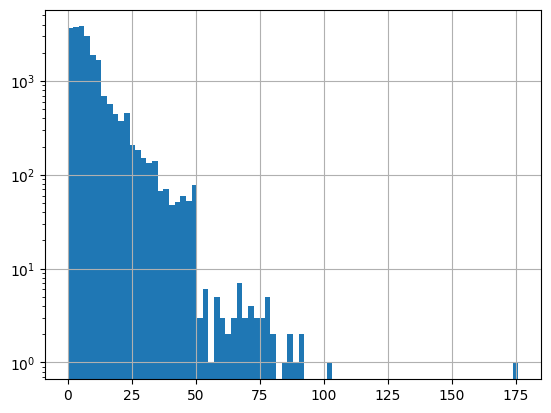

In [8]:
categroies.keywords.map(len).hist(bins=80, log=True)